# Datasets
- Occupations by State and Likelihood of Automation: https://data.world/wnedds/occupations-by-state-and-likelihood-of-automation

- SOC categories: "scraped" from https://www.bls.gov/soc/2018/home.htm

# Data ingestion, cleaning, assigning

In [1]:
## Setup
import pandas as pd
import seaborn as sns
import numpy as np
import patsy
import statsmodels.api as sm
from scipy import stats

In [2]:
## Cleaning
# Function tidy-izes the data
def organize(df, year):
    df = df[7:]
    df = df.rename(columns={df.columns[0]: 'Occupation', df.columns[1]: 'Total{}'.format(year)})
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df = df[['Occupation', 'Total{}'.format(year)]]

    
    return df

In [3]:
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
          'Georgia', 'Hawaii', 'Idaho', 'Illinois','Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
          'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
          'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
          'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
          'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

In [4]:
## Cleaning
# Creates and cleans dataframes for the year
# Note: number of employees is listed in thousands
employment2013 = organize(pd.read_excel('../datasets/blsdata/cpsaat11b2013.xlsx'), 2013)
employment2014 = organize(pd.read_excel('../datasets/blsdata/cpsaat11b2014.xlsx'), 2014)
employment2015 = organize(pd.read_excel('../datasets/blsdata/cpsaat11b2015.xlsx'), 2015)
employment2016 = organize(pd.read_excel('../datasets/blsdata/cpsaat11b2016.xlsx'), 2016)
employment2017 = organize(pd.read_excel('../datasets/blsdata/cpsaat11b2017.xlsx'), 2017)
employment2018 = organize(pd.read_excel('../datasets/blsdata/cpsaat11b2018.xlsx'), 2018)
employment2019 = organize(pd.read_excel('../datasets/blsdata/cpsaat11b2019.xlsx'), 2019)

employment = pd.merge(pd.merge(employment2013, pd.merge(employment2014, employment2015)), pd.merge(pd.merge(employment2016, employment2017), pd.merge(employment2018, employment2019)))

In [5]:
## Cleaning
# Read in data
df_occ = pd.read_csv('../datasets/raw_state_automation_data.csv', encoding='cp1252')
soc = pd.read_csv('../datasets/SOC.csv')
#employment2016 = pd.read_csv('datasets/cpsaat11b.csv')

In [6]:
## Cleaning
# Structure main dataset
df_occ.sort_values(by=['SOC'], inplace=True)

In [7]:
## Cleaning
# Standardize data name
soc.rename(columns={'  Occupation':'Occupation'}, inplace=True)

In [8]:
## Cleaning
# Standardize occupation names
employment['Occupation'] = employment['Occupation'].apply(lambda x: x.title())
df_occ['Occupation'] = df_occ['Occupation'].apply(lambda x: x.title())

In [9]:
df_occ.head()

,SOC,Occupation,Probability,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,11-1011,Chief Executives,0.015,1030,760,5750,2710,31150,880,1410,...,560,5460,5890,3650,280,6320,5910,980,3740,160
1,11-1021,General And Operations Managers,0.160,26930,6490,43300,20680,261780,41540,33280,...,3730,44400,168610,36200,2760,52380,43760,10200,32350,4840
2,11-2011,Advertising And Promotions Managers,0.039,50,40,470,110,3760,480,300,...,0,670,1210,380,40,240,640,40,200,0
3,11-2021,Marketing Managers,0.014,530,200,4790,1090,33390,3060,4970,...,60,3400,9570,2320,380,3840,5830,260,2980,30
4,11-2022,Sales Managers,0.013,2510,400,10650,2650,69180,4570,7040,...,300,8890,22310,3360,480,5360,7390,600,5730,180


In [10]:
soc.head()

,Code_Prefix,Occupation
0,11-0000,Management Occupations
1,11-1000,Top Executives
2,Nov-00,"Advertising, Marketing, Promotions, Public Re..."
3,Nov-00,Operations Specialities Managers
4,Nov-00,Other Management Occupations


# Initial Analysis

## Look at variable distributions

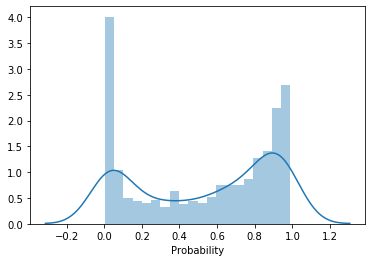

In [11]:
## Analysis
# Distribution of probability of automation
sns.distplot(df_occ.Probability, bins=20)

## Additional data exploration

In [12]:
# Average probability of automation: 53%
mean_probability = df_occ.Probability.mean()

In [13]:
# Average probability of automation for management positions: 16%
mean_management_probability = df_occ[df_occ.SOC.str.startswith('11')].Probability.mean()

In [14]:
# Adds a 'total_employees' column for each occupation, converts to integer
total = []

for i in range(len(df_occ)):
    total.append(df_occ.loc[i, [state for state in states]].values.sum())

df_occ = df_occ.assign(total_employees = total)

df_occ.total_employees = df_occ.total_employees.astype(int)

[[1.         0.08169575]
 [0.08169575 1.        ]]


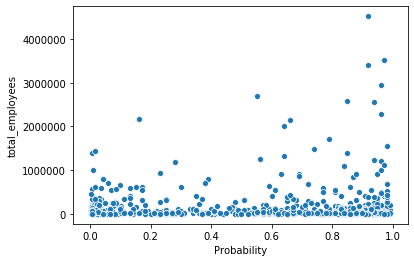

In [15]:
# There is almost no correlation between number of employees and probability of automation
sns.scatterplot(df_occ.Probability, df_occ.total_employees)
print(np.corrcoef(df_occ.Probability, df_occ.total_employees))

In [16]:
# Statistics for probability of 10th percentile of employees
df_occ[df_occ.total_employees >= np.percentile(df_occ.total_employees, 10)].Probability.describe()

count    631.000000
mean       0.534153
std        0.367298
min        0.002800
25%        0.105000
50%        0.640000
75%        0.890000
max        0.990000
Name: Probability, dtype: float64

In [17]:
# Create a dictionary of SOCs
soc_dict = {key:value for (key,value) in zip(soc.Code_Prefix, soc.Occupation)}

In [18]:
# Add base-level occupation category for each occupation
prefix = []
for index in range(len(df_occ)):
    prefix.append(df_occ.SOC[index][:3])

prefix = [substring + '0000' for substring in prefix]
occupation_category = [soc_dict[item] for item in prefix]
occupation_category = [item[1:] for item in occupation_category]

df_occ = df_occ.assign(Category = occupation_category)

In [19]:
# Probability stats for each base-level occupational category
df_occ.groupby('Category').Probability.describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Architecture and Engineering Occupations,34.0,0.279382,0.318716,0.0100,0.022000,0.1200,0.4875,0.96
"Arts, Design, Entertainment, Sports, and Media Occupations",36.0,0.238014,0.302714,0.0040,0.022750,0.0780,0.3725,0.98
Building and Grounds Cleaning and Maintenance Occupations,8.0,0.776250,0.156565,0.5700,0.660000,0.7300,0.9425,0.97
Business and Financial Operations Occupations,30.0,0.552100,0.378403,0.0120,0.230000,0.5750,0.9400,0.99
Community and Social Service Occupations,13.0,0.043262,0.070746,0.0031,0.008100,0.0140,0.0330,0.25
Computer and Mathematical Operations,15.0,0.221033,0.281492,0.0065,0.032500,0.1300,0.2200,0.99
Construction and Extraction Occupations,56.0,0.732857,0.191944,0.1500,0.627500,0.8100,0.8700,0.96
Educational Instruction and Library Occupations,22.0,0.225095,0.297054,0.0042,0.007725,0.0810,0.3575,0.99
"Farming, Fishing, and Forestry Occupations",11.0,0.793636,0.169957,0.4100,0.765000,0.8300,0.9050,0.97


In [20]:
df_occ.Category.value_counts()

Production Occupations                                        103
Construction and Extraction Occupations                        56
Office and Administrative Support Occupations                  52
Installation, Maintenance, and Repair Occupations              50
Transportation and Material Moving Occupations                 48
Healthcare Practitioners and Technical Occupations             44
Life, Physical, and Social Science Occupations                 42
Arts, Design, Entertainment, Sports, and Media Occupations     36
Architecture and Engineering Occupations                       34
Management Occupations                                         31
Business and Financial Operations Occupations                  30
Personal Care and Service Occupations                          30
Educational Instruction and Library Occupations                22
Sales and Related Occupations                                  20
Protective Service Occupations                                 19
Food Prepa

In [21]:
# Do some voodoo dictionary stuff to get probabilities and number of jobs in occupation
category_vals = dict(df_occ.Category.value_counts())
prob_vals = dict(df_occ.groupby('Category').Probability.mean())
sorted_cat = sorted(set(category_vals.items()))
sorted_prob = sorted(set(prob_vals.items()))
nums_cat = [num for (cat,num) in sorted_cat]
nums_prob = [prob for (cat,prob) in sorted_prob]

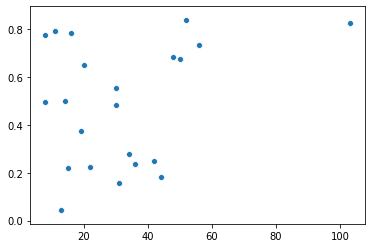

In [22]:
# Plots number of jobs in occupation vs likelihood of automation
sns.scatterplot(nums_cat, nums_prob)

In [23]:
# Dataframes for the top/bottom 5% probability-wise
data_95 = df_occ[df_occ.Probability >= .95]
data_05 = df_occ[df_occ.Probability <= .05]

In [24]:
# Look at the 5% of jobs least likely to be automated
data_05.head()

,SOC,Occupation,Probability,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,...,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,total_employees,Category
0,11-1011,Chief Executives,0.015,1030,760,5750,2710,31150,880,1410,...,5890,3650,280,6320,5910,980,3740,160,220430,Management Occupations
2,11-2011,Advertising And Promotions Managers,0.039,50,40,470,110,3760,480,300,...,1210,380,40,240,640,40,200,0,27860,Management Occupations
3,11-2021,Marketing Managers,0.014,530,200,4790,1090,33390,3060,4970,...,9570,2320,380,3840,5830,260,2980,30,204620,Management Occupations
4,11-2022,Sales Managers,0.013,2510,400,10650,2650,69180,4570,7040,...,22310,3360,480,5360,7390,600,5730,180,364070,Management Occupations
5,11-2031,Public Relations And Fundraising Managers,0.015,400,150,1240,300,7010,960,980,...,3680,380,210,1250,2100,130,1010,0,59590,Management Occupations


In [25]:
# Look at the 5% of jobs most likely to be automated

data_95.head()

,SOC,Occupation,Probability,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,...,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,total_employees,Category
12,11-3111,Compensation And Benefits Managers,0.96,90,0,300,150,1590,190,250,...,690,170,0,360,380,0,340,0,14980,Management Occupations
35,13-1031,Claims Adjusters; Examiners; And Investigators,0.98,3730,290,0,1450,32540,3340,4980,...,19650,1910,240,5110,5730,1340,6230,150,264450,Business and Financial Operations Occupations
36,13-1032,Insurance Appraisers; Auto Damage,0.98,0,0,460,0,0,90,210,...,1840,70,0,540,270,0,70,0,10790,Business and Financial Operations Occupations
39,13-1074,Farm Labor Contractors,0.97,0,0,0,0,350,0,0,...,0,0,0,0,0,0,0,0,350,Business and Financial Operations Occupations
51,13-2041,Credit Analysts,0.98,490,0,1130,520,7910,1300,1240,...,7940,830,100,1840,900,100,1850,40,67530,Business and Financial Operations Occupations


In [26]:
# Look at job codes for the jobs most likely to be automated
data_95.SOC.values

array(['11-3111', '13-1031', '13-1032', '13-1074', '13-2041', '13-2053',
       '13-2072', '13-2082', '15-2091', '17-3031', '19-4011', '23-2093',
       '25-4031', '27-2023', '27-4013', '33-9031', '35-2014', '35-3022',
       '35-9031', '37-3011', '37-3012', '39-3011', '39-3021', '39-3031',
       '39-5092', '41-2011', '41-2021', '41-2022', '41-9012', '41-9021',
       '41-9041', '43-2011', '43-2021', '43-3011', '43-3021', '43-3031',
       '43-3051', '43-3061', '43-3071', '43-4011', '43-4041', '43-4071',
       '43-4121', '43-4141', '43-4151', '43-4171', '43-5011', '43-5032',
       '43-5051', '43-5071', '43-5111', '43-6012', '43-6014', '43-9021',
       '43-9041', '43-9061', '45-2021', '45-4023', '47-2073', '47-5051',
       '49-9061', '49-9064', '49-9093', '51-2022', '51-2023', '51-2092',
       '51-2093', '51-4033', '51-4035', '51-4072', '51-5111', '51-5113',
       '51-6042', '51-6051', '51-6061', '51-6062', '51-6064', '51-7031',
       '51-7042', '51-8011', '51-9021', '51-9022', 

In [27]:
# Top 95% looks to contain a lot of 51- prefix, lets see what it is
soc[soc.Code_Prefix == '51-0000']

,Code_Prefix,Occupation
99,51-0000,Production Occupations


In [28]:
# Look at job codes for the jobs least likely to be automated
data_05.SOC.values

array(['11-1011', '11-2011', '11-2021', '11-2022', '11-2031', '11-3021',
       '11-3051', '11-3061', '11-3121', '11-3131', '11-9013', '11-9031',
       '11-9032', '11-9033', '11-9041', '11-9081', '11-9111', '11-9121',
       '11-9151', '11-9161', '13-1081', '13-1121', '13-1151', '13-2071',
       '15-1111', '15-1121', '15-1132', '15-1141', '15-1142', '15-2021',
       '15-2031', '17-1011', '17-1012', '17-2011', '17-2031', '17-2041',
       '17-2051', '17-2072', '17-2081', '17-2111', '17-2112', '17-2121',
       '17-2131', '17-2141', '17-2199', '17-3026', '19-1013', '19-1021',
       '19-1022', '19-1029', '19-1031', '19-1032', '19-1042', '19-2011',
       '19-2032', '19-2041', '19-2043', '19-3031', '19-3032', '19-3039',
       '19-3091', '19-3094', '19-3099', '19-4092', '21-1011', '21-1012',
       '21-1013', '21-1014', '21-1015', '21-1021', '21-1022', '21-1023',
       '21-1091', '21-2011', '21-2021', '23-1011', '25-1000', '25-2011',
       '25-2021', '25-2031', '25-2032', '25-2053', 

In [29]:
# Bottom 5% contains a lot of 11-, 19-, 29- prefixs
soc[soc.Code_Prefix == '11-0000']

,Code_Prefix,Occupation
0,11-0000,Management Occupations


In [30]:
soc[soc.Code_Prefix == '19-0000']

,Code_Prefix,Occupation
15,19-0000,"Life, Physical, and Social Science Occupations"


In [31]:
soc[soc.Code_Prefix == '29-0000']

,Code_Prefix,Occupation
38,29-0000,Healthcare Practitioners and Technical Occupa...


# Look at data without state information

## Data creation & cleaning

In [32]:
## Cleaning
# Clean up dataset to include the variables we want to consider
df_occ_trim = df_occ[['SOC', 'Occupation','Category' , 'Probability']]

In [33]:
## Cleaning
# Include employment info
df_occ_trim = pd.merge(df_occ_trim, employment)

In [34]:
# Look at the data
df_occ_trim.head()

,SOC,Occupation,Category,Probability,Total2013,Total2014,Total2015,Total2016,Total2017,Total2018,Total2019
0,11-1011,Chief Executives,Management Occupations,0.015,1520,1603,1517,1649,1639,1573,1602
1,11-1021,General And Operations Managers,Management Occupations,0.160,1075,887,899,949,1005,1037,1058
2,11-2011,Advertising And Promotions Managers,Management Occupations,0.039,51,52,67,67,61,44,55
3,11-2031,Public Relations And Fundraising Managers,Management Occupations,0.015,55,71,61,62,73,69,73
4,11-3011,Administrative Services Managers,Management Occupations,0.730,113,134,195,181,151,161,184


In [35]:
## Cleaning
# Add percent change based on 2013 to 2019 data
df_occ_trim['percent_change'] = (df_occ_trim.Total2019 - df_occ_trim.Total2013)/df_occ_trim.Total2013
df_occ_trim.head()

,SOC,Occupation,Category,Probability,Total2013,Total2014,Total2015,Total2016,Total2017,Total2018,Total2019,percent_change
0,11-1011,Chief Executives,Management Occupations,0.015,1520,1603,1517,1649,1639,1573,1602,0.0539474
1,11-1021,General And Operations Managers,Management Occupations,0.160,1075,887,899,949,1005,1037,1058,-0.015814
2,11-2011,Advertising And Promotions Managers,Management Occupations,0.039,51,52,67,67,61,44,55,0.0784314
3,11-2031,Public Relations And Fundraising Managers,Management Occupations,0.015,55,71,61,62,73,69,73,0.327273
4,11-3011,Administrative Services Managers,Management Occupations,0.730,113,134,195,181,151,161,184,0.628319


## Variable Distributions

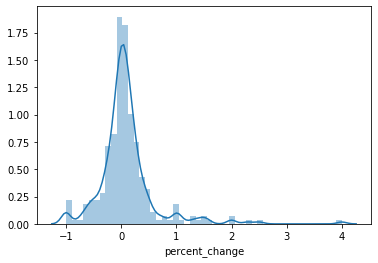

In [36]:
## Analysis
# Distribution of percent change in employment
sns.distplot(df_occ_trim.percent_change)

In [37]:
## Analysis
# Investigate outlier
df_occ_trim[df_occ_trim.percent_change >= 3.5]

,SOC,Occupation,Category,Probability,Total2013,Total2014,Total2015,Total2016,Total2017,Total2018,Total2019,percent_change
121,33-3052,Transit And Railroad Police,Protective Service Occupations,0.57,1,3,1,2,7,2,5,4


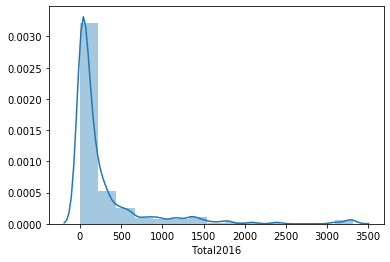

In [38]:
# Distribution of employment for a given year
sns.distplot(df_occ_trim.Total2016, bins = 15)

Shows that most occupations have less than ~300,000 employees (employment number in thousands), with large outlier around 3 million

In [39]:
# Occupations with over 3,000,000 employees
df_occ_trim[df_occ_trim.Total2016 > 3000]

,SOC,Occupation,Category,Probability,Total2013,Total2014,Total2015,Total2016,Total2017,Total2018,Total2019,percent_change
95,29-1111,Registered Nurses,Healthcare Practitioners and Technical Occupat...,0.009,2892,2888,2973,3102,3159,3213,3242,0.121024
143,41-1011,First-Line Supervisors Of Retail Sales Workers,Sales and Related Occupations,0.280,3223,3285,3245,3282,3272,3366,3232,0.00279243
145,41-2011,Cashiers,Sales and Related Occupations,0.970,3254,3242,3246,3260,3253,3200,3164,-0.0276583
148,41-2031,Retail Salespersons,Sales and Related Occupations,0.920,3230,3316,3346,3312,3235,3147,3105,-0.0386997


## Data analysis

In [40]:
# Determine normality of percent_change
k2, p = stats.normaltest(df_occ_trim.percent_change)
print(p)

7.761901649323115e-42


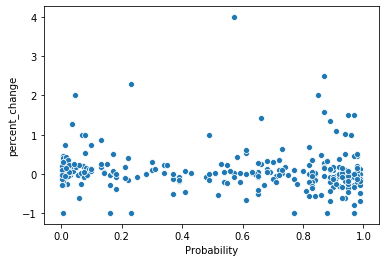

In [41]:
## Analysis
# Plot the percent change vs Probability of employment
sns.scatterplot(df_occ_trim.Probability, df_occ_trim.percent_change)

In [42]:
## Analysis
# Does this data mean anything?
# (Hint: No, it doesn't)

# NOTE: Data does not meet requirements necessary for testing linearity, but want to take a look 

outcome, predictors = patsy.dmatrices('Probability ~ percent_change', df_occ_trim)
model = sm.OLS(outcome, predictors)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Probability   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                 -0.061
Method:                 Least Squares   F-statistic:                    0.9333
Date:                Tue, 09 Jun 2020   Prob (F-statistic):              0.633
Time:                        12:03:58   Log-Likelihood:                 143.79
No. Observations:                 274   AIC:                             186.4
Df Residuals:                      37   BIC:                             1043.
Df Model:                         236                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------